# Import the necessary libraries

In [11]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

### Load the data into Pandas dataframe

In [2]:
df = pd.read_csv('spam.csv',delimiter=',',encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Drop the columns that are not required for the neural network.

In [3]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
v1    5572 non-null object
v2    5572 non-null object
dtypes: object(2)
memory usage: 87.2+ KB


Understand the distribution better.

Text(0.5, 1.0, 'Number of ham and spam messages')

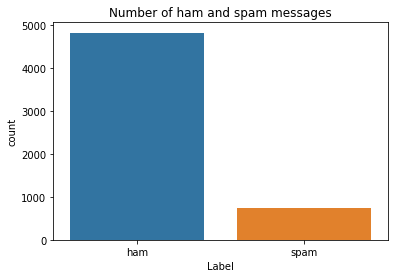

In [4]:
sns.countplot(df.v1)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

* Create input and output vectors.
* Process the labels.

##### Label Encoder:
Encode labels with value between 0 and n_classes-1.

In [5]:
X = df.v2
Y = df.v1
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

Split into training and test data.

In [6]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

### Process the data
* Tokenize the data and convert the text to sequences.
* Add padding to ensure that all the sequences have the same shape.
* There are many ways of taking the *max_len* and here an arbitrary length of 150 is chosen.

##### 1. Keras Text Tokenizer
This class allows to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary, based on word count, based on tf-idf...

##### 2. texts_to_sequences: 
Transform each text in texts in a sequence of integers. 

##### 3. Keras Pad Sequences:
Pads sequences to the same length.

In [7]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

### RNN
Define the RNN structure.

RNN is a recurrent neural network. It is a type of deep learning model. Unlike feed-forward neural networks, recurrent neural networks have a backward connection between hidden layers. Therefore, they have some kind of memory in them.

##### 1. Keras Embedding Layer 
Keras offers an Embedding layer that can be used for neural networks on text data. It requires that the input data be integer encoded, so that each word is represented by a unique integer. This data preparation step can be performed using the Tokenizer API also provided with Keras.

##### 2. LSTM
Long Short Term Memory networks, usually called “LSTMs” , were introduced by Hochreiter and Schmiduber. These have widely been used for speech recognition, language modeling, sentiment analysis and text prediction.

LSTM has a special architecture which enables it to forget the unnecessary information .

##### 3. ReLU activation function

ReLU (rectified linear unit) is one of the most popular function which is used as hidden layer activation function in deep neural network. ReLU activation function is defined as. g ( z ) = max { 0 , z }.

##### 4. Dropout
Dropout is a technique where randomly selected neurons are ignored during training. They are “dropped-out” randomly. This means that their contribution to the activation of downstream neurons is temporally removed on the forward pass and any weight updates are not applied to the neuron on the backward pass.

The effect is that the network becomes less sensitive to the specific weights of neurons. This in turn results in a network that is capable of better generalization and is less likely to overfit the training data.

##### 5. Sigmoid Activation Function
A sigmoid function is a mathematical function having a characteristic "S"-shaped curve or sigmoid curve. 

In [8]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

Call the function and compile the model.

In [12]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_3 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257 

In [13]:
import warnings
warnings.filterwarnings('ignore')

Fit on the training data.

In [14]:
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])


Train on 3788 samples, validate on 948 samples
Epoch 1/10
3788/3788 [==============================] - 11s 3ms/step - loss: 0.3471 - accuracy: 0.8598 - val_loss: 0.1512 - val_accuracy: 0.9409
Epoch 2/10
3788/3788 [==============================] - 10s 3ms/step - loss: 0.0972 - accuracy: 0.9747 - val_loss: 0.0555 - val_accuracy: 0.9842
Epoch 3/10
3788/3788 [==============================] - 10s 3ms/step - loss: 0.0466 - accuracy: 0.9863 - val_loss: 0.0631 - val_accuracy: 0.9810


The model performs well on the validation set and this configuration is chosen as the final model.

Process the test set data.

In [15]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

Evaluate the model on the test set.

In [16]:
accr = model.evaluate(test_sequences_matrix,Y_test)

836/836 [==============================] - 1s 901us/step


In [17]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.046
  Accuracy: 0.986


source for attention: [https://github.com/philipperemy/keras-attention-mechanism/blob/master/attention_lstm.py](http://)
source for other code: [https://www.kaggle.com/kredy10/simple-lstm-for-text-classification/notebook](http://)

##### Attention
Attention is a mechanism combined in the RNN allowing it to focus on certain parts of the input sequence when predicting a certain part of the output sequence, enabling easier learning and of higher quality. 

In [18]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [19]:
SINGLE_ATTENTION_VECTOR = False
APPLY_ATTENTION_BEFORE_LSTM = False
def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Reshape((input_dim, TIME_STEPS))(a) # this line is not useful. It's just to know which dimension is what.
    a = Dense(TIME_STEPS, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    # output_attention_mul = merge([inputs, a_probs], name='attention_mul', mode='mul')
    output_attention_mul = multiply([inputs, a_probs])
    return output_attention_mul

In [20]:
def model_attention_applied_after_lstm():
    #inputs = Input(shape=(TIME_STEPS, INPUT_DIM,))
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    
    lstm_units = 64
    lstm_out = LSTM(lstm_units, return_sequences=True)(layer)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = Flatten()(attention_mul)
    output = Dense(1, activation='sigmoid')(attention_mul)
    model = Model(input=[inputs], output=output)
    return model

In [21]:
from keras.layers import merge
from keras.layers import multiply
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *

from keras.utils.vis_utils import plot_model

In [22]:
INPUT_DIM = 50
TIME_STEPS = max_len

In [23]:
sequences_matrix.shape,Y_train.shape

((4736, 150), (4736, 1))

In [24]:
m = model_attention_applied_after_lstm()

In [26]:
m.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 150)          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 150, 50)      50000       inputs[0][0]                     
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 150, 64)      29440       embedding_3[0][0]                
__________________________________________________________________________________________________
permute_1 (Permute)             (None, 64, 150)      0           lstm_3[0][0]                     
____________________________________________________________________________________________

In [27]:
m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
m.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Train on 3788 samples, validate on 948 samples
Epoch 1/10
3788/3788 [==============================] - 15s 4ms/step - loss: 0.5775 - accuracy: 0.8379 - val_loss: 0.4028 - val_accuracy: 0.8639
Epoch 2/10
3788/3788 [==============================] - 13s 3ms/step - loss: 0.3981 - accuracy: 0.8651 - val_loss: 0.3977 - val_accuracy: 0.8639
Epoch 3/10
3788/3788 [==============================] - 13s 4ms/step - loss: 0.3924 - accuracy: 0.8651 - val_loss: 0.3876 - val_accuracy: 0.8639
Epoch 4/10
3788/3788 [==============================] - 13s 3ms/step - loss: 0.3732 - accuracy: 0.8651 - val_loss: 0.3552 - val_accuracy: 0.8639
Epoch 5/10
3788/3788 [==============================] - 13s 3ms/step - loss: 0.3293 - accuracy: 0.8651 - val_loss: 0.2953 - val_accuracy: 0.8639
Epoch 6/10
3788/3788 [==============================] - 13s 3ms/step - loss: 0.2542 - accuracy: 0.8886 - val_loss: 0.2033 - val_accuracy: 0.9378
Epoch 7/10
3788/3788 [==============================] - 13s 3ms/step - loss: 0.2026

In [28]:
accr = m.evaluate(test_sequences_matrix,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

836/836 [==============================] - 1s 1ms/step
Test set
  Loss: 0.091
  Accuracy: 0.975
